In [133]:
import numpy as np
import seaborn as sb

In [137]:
def intervalo_confianza(lista):
    media = np.mean(lista)
    valor_z = 2.57
    desvio = np.std(lista)
    n = len(lista)
    
    ext_inferior = media - (valor_z * (desvio/(n ** 0.5)))
    ext_superior = media + (valor_z * (desvio/(n ** 0.5)))
    return ext_inferior, ext_superior

In [199]:
class Empleado():
    def __init__(self, tipo):
        if tipo == 1:
            self.nombre = "Empleado tipo 1"
            self.tiempoAtencion = np.random.normal(18,4) #Normal de media 18 minutos y Desv.est. de 4 minutos.
        elif tipo == 2:
            self.nombre = "Empleado tipo 2"
            self.tiempoAtencion = np.random.exponential(15) #Exponencial con tiempo promedio de 15 minutos. 
        elif tipo == 3:
            self.nombre = "Empleado tipo 3"
            self.tiempoAtencion = np.random.exponential(16) #Exponencial con promedio de 16 minutos.
        elif tipo ==4:
            self.nombre = "Empleado tipo 4"
            self.tiempoAtencion = np.random.normal(14,3) #Normal de media 14 minutos y desv.est. de 3 minutos.
        else:
            self.nombre = "Empleado tipo 5"
            self.tiempoAtencion = np.random.normal(19,5) #Normal de media 19 minutos y desv.est. de 5 minutos.


In [200]:
class Camion():
    def __init__(self, id_camion):
        self.id = id_camion
        self.tiempoLlegada = int(np.random.exponential(15))
        self.tiempoInicioAtencion = -1
        
    def __repr__(self):
        return f"id: {self.id} - hora llegada: {self.tiempoLlegada} - hora en que fue atendido: {self.tiempoInicioAtencion}"

In [201]:
class Surtidor():
    def __init__(self, tipo):
        self.tipo = tipo
        self.ocupado = False
        self.tiempoOcupacion = 0
        self.tiempoAtencion = Empleado(tipo).tiempoAtencion
        
    def marcarLibre(self):
        self.ocupado = False
    
    def marcarOcupado(self):
        self.ocupado = True
    
    def actualizarPorcentajeOcupacion(self, reloj):
        self.tiempoOcupacion = self.tiempoOcupacion + reloj

In [202]:
class Evento():
    """
    nombre = puede ser ARRIBO_CAMION, FIN_ATENCION
    objeto = puede ser un Camion o un Surtidor
    duracion = duracion del evento
    """
    def __init__(self, _id, nombre, objeto, arribo, duracion):
        self.id = _id
        self.nombre = nombre
        self.arribo = arribo
        self.duracion = duracion
        self.tiempo_fin = arribo + duracion
        self.objeto = objeto
        
    def __repr__(self):
        return f"{self.id} - {self.nombre} - arribo: {self.arribo} - duracion: {self.duracion} - termina: {self.tiempo_fin}\n"
    
    
class EventoFinAtencion(Evento):
    def __init__(self, evento_inicio, **kwargs):
        super(EventoFinAtencion, self).__init__(**kwargs)
        self.evento_inicio = evento_inicio
    
    def __repr__(self):
        return f"{self.id} - {self.nombre} a {self.evento_inicio.id} - inicia: {self.arribo} - duracion: {self.duracion} - termina: {self.tiempo_fin}\n"

In [203]:
def inicializarModelo(prefijo, cantidad_camiones, cantidad_surtidores):
    fel = []
    lista_surtidores = []
    for id_camion in range(cantidad_camiones): 
        camion = Camion(f"{prefijo}-C{id_camion}") # agrego un prefijo al id
        fel.append(Evento(f"{prefijo}-C{id_camion}", "ARRIBO_CAMION", camion, camion.tiempoLlegada, 0))
    
    for i in range(1,(cantidad_surtidores+1)):
        lista_surtidores.append(Surtidor(i))
        
    return ordenarEventos(fel), lista_surtidores   

In [204]:
def haySurtidorLibre(lista_surtidores):
    return any(not surtidor.ocupado  for surtidor in lista_surtidores)

In [205]:
def getSurtidorLibre(lista_surtidores):
    for surtidor in lista_surtidores:
        if (not surtidor.ocupado):
            return surtidor

In [206]:
def ordenarEventos(fel):
    fel.sort(key=lambda evento: evento.arribo)
    return fel

In [207]:
def removerEvento(fel, evento): #remueve el siguiente evento de la FEL
    if evento in fel:
        fel.remove(evento)
    return ordenarEventos(fel)

In [208]:
def agregarEvento(fel, evento): #agrega un nuevo evento y ordena la FEL
    fel.append(evento)
    return ordenarEventos(fel)

In [209]:
def calcularOcupacionSurtidores(ocupacion_surtidores, lista_surtidores, reloj_simulacion, i,j):
    ocupacion_surtidores[(i,j)]={ "surtidor1": lista_surtidores[0].tiempoOcupacion / reloj_simulacion,
                                    "surtidor2": lista_surtidores[1].tiempoOcupacion / reloj_simulacion,
                                    "surtidor3": lista_surtidores[2].tiempoOcupacion / reloj_simulacion,
                                    "surtidor4": lista_surtidores[3].tiempoOcupacion / reloj_simulacion}
    if (len(lista_surtidores) == 5):
        ocupacion_surtidores[(i,j)]={"surtidor5": lista_surtidores[4].tiempoOcupacion / reloj_simulacion}


In [251]:
def simulacion(experimentos, corridas,camiones, surtidores):
    cant_experimentos = experimentos
    cant_corridas = corridas
    cant_camiones = camiones
    cant_surtidores = surtidores
    total_camiones = cant_experimentos*cant_corridas*cant_camiones
    demora_promedio_corrida = []
    ocupacion_surtidores = {}

    for i in range(cant_experimentos):
        for j in range(cant_corridas):
            reloj_simulacion = 0
            prefijo = f"{i}{j}" # un prefijo para identificar los eventos de cada experimento/corrida
            fel, lista_surtidores = inicializarModelo(prefijo, cant_camiones, cant_surtidores)
            demoras = []

            k = 0 
            while len(fel) > 0: #procesamos mientras la lista tenga eventos
                evento = fel[k]
                reloj_simulacion += evento.arribo

                if evento.nombre == "ARRIBO_CAMION":
                    if haySurtidorLibre(lista_surtidores):
                        surtidor = getSurtidorLibre(lista_surtidores)
                        surtidor.marcarOcupado()
                        surtidor.actualizarPorcentajeOcupacion(reloj_simulacion)
                        evento_fin_atencion = EventoFinAtencion(evento_inicio=evento, #evento_inicio es el evento arribo relacionado al evento Fin de atencion
                                                                nombre="FIN_ATENCION", 
                                                                objeto=surtidor, 
                                                                _id=f"{prefijo}-F{k}",
                                                                arribo=reloj_simulacion, 
                                                                duracion=surtidor.tiempoAtencion) 
                        fel = agregarEvento(fel, evento_fin_atencion)
                        demora = reloj_simulacion - evento.arribo #calculamos la demora en atender a este camion.
                        demoras.append(demora)
                        evento.objeto.tiempoInicioAtencion = reloj_simulacion # como fue atendido, seteamos este atributo al camion.

                if evento.nombre == "FIN_ATENCION":
                    evento.objeto.marcarLibre()
                    evento.objeto.actualizarPorcentajeOcupacion(0)
                    evento_inicio = evento.evento_inicio #evento_inicio sirve para quitar ambos eventos (arribo y espera) de la FEL
                    fel = removerEvento(fel, evento)
                    fel = removerEvento(fel, evento_inicio)


                k += 1
                if k >= len(fel):
                    if len(fel) > 0: # siguen habiendo eventos por procesar, reseteamos k.
                        k = 0 
                    else:
                        break
            demora_promedio_corrida.append(np.mean(demoras))
            calcularOcupacionSurtidores(ocupacion_surtidores, lista_surtidores, reloj_simulacion, i,j)
    return demora_promedio_corrida, ocupacion_surtidores

In [252]:
demora_promedio_corrida, ocupacion_surtidores = simulacion(experimentos=60, corridas=100, camiones=10, surtidores=4)

### Demora Promedio de los camiones

In [255]:
print(f"Demora promedio {np.mean(demora_promedio_corrida):.2f}")

Demora promedio 565.37


### Intervalo de confianza con un nivel de confiabilidad del 99%.

In [263]:
intervalo_confianza(demora_promedio_corrida)

(770.3608030049282, 803.688047082457)

### Histograma de la simulación (tiempos promedio por cada experimento).

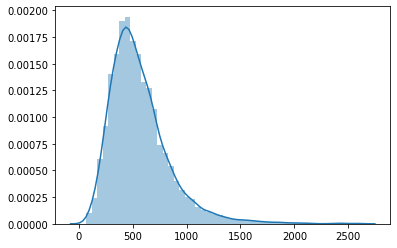

In [257]:
grafico = sb.distplot(demora_promedio_corrida)

### Calcule el porcentaje de tiempo de ocupación de cada surtidor.

In [258]:
ocupacion_surtidor1 = 0
ocupacion_surtidor2 = 0
ocupacion_surtidor3 = 0
ocupacion_surtidor4 = 0
i = 0
resultado = {}

for key, value in ocupacion_surtidores.items():
    i+=1
    ocupacion_surtidor1 = ocupacion_surtidor1 + value['surtidor1']
    ocupacion_surtidor2 = ocupacion_surtidor2 + value['surtidor2']
    ocupacion_surtidor3 = ocupacion_surtidor3 + value['surtidor3']
    ocupacion_surtidor4 = ocupacion_surtidor4 + value['surtidor4']

resultado[0] = str(round((ocupacion_surtidor1/i),2))+"%"
resultado[1] = str(round((ocupacion_surtidor2/i),2))+"%"
resultado[2] = str(round((ocupacion_surtidor3/i),2))+"%"
resultado[3] = str(round((ocupacion_surtidor4/i),2))+"%"
print("Ocupacion Surtidores:")
print(resultado)

Ocupacion Surtidores:
{0: '0.28%', 1: '0.28%', 2: '0.18%', 3: '0.22%'}


### Realice la simulación pero esta vez, añadiendo un nuevo surtidor cuyo empleado tenga una capacidad de atención Normal (media = 19 min, desvío = 5 min.) y analice los resultados. ¿Los camiones pasan menos tiempo en espera?

In [259]:
demora_promedio_corrida, ocupacion_surtidores = simulacion(experimentos=60, corridas=100, camiones=10, surtidores=5)

### Resultado con un 5to surtidor agregado

### Demora Promedio de los camiones

In [262]:
print(f"Demora promedio {np.mean(demora_promedio_corrida):.2f}")

Demora promedio 787.02


Este resultado me indica que el promedio de espera de los camiones es mas elevado que en la situacion anterior en la que tenia solo 4 surtidores disponibles.

### Calcule la cantidad necesaria de surtidores y sus características de atención*, para disminuir el tiempo de espera en un 30%.

Tomando en cuenta que el tiempo de espera de los clientes en promedio es de 3748.64 reducirlo en un 30%
implicaria que el promedio de espera queda en un valor aproximado de 2624.048. Realizando una regla de 3 si
con 4 maquinas obtengo un promedio de 3748.64 entonces necesitaria aproximadamente 4 maquinas mas.